
Import Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as Func

In [ ]:
data = pd.read_csv("MovieLens.csv")
print(data.head(10))

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
5       1       70     3.0  964982400
6       1      101     5.0  964980868
7       1      110     4.0  964982176
8       1      151     5.0  964984041
9       1      157     5.0  964984100


In [ ]:
#fix the seed to make consistent
np.random.seed(4)

#separate the data into training and validation(testing)
mask = np.random.rand(len(data)) < 0.75
train = data[mask].copy()
val = data[~mask].copy()

In [ ]:
def proc_col(col, train_col=None):
    if train_col is not None:
        uniq = train_col.unique()
    else:
        uniq = col.unique()
    name2idx = {o:i for i,o in enumerate(uniq)}
    return name2idx, np.array([name2idx.get(x, -1) for x in col]), len(uniq)

In [ ]:
def encode_data(df, train=None):
    df = df.copy()
    for col_name in ["userId", "movieId"]:
        train_col = None
        if train is not None:
            train_col = train[col_name]
        _,col,_ = proc_col(df[col_name], train_col)
        df[col_name] = col
        df = df[df[col_name] >= 0]
    return df

In [ ]:
df_train = encode_data(train)
df_val = encode_data(val, train)
print(df_train.head(10))

    userId  movieId  rating  timestamp
1        0        0     4.0  964981247
3        0        1     5.0  964983815
4        0        2     5.0  964982931
5        0        3     3.0  964982400
7        0        4     4.0  964982176
8        0        5     5.0  964984041
9        0        6     5.0  964984100
11       0        7     5.0  964981208
14       0        8     4.0  964980908
15       0        9     5.0  964981680


Training Function

In [ ]:
def train_epocs(model, epochs = 10, lr = 0.01, wd = 0.0):
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)#using SGD to optimize
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) #using Adam to optimize
    model.train()
    for i in range(epochs):
        users = torch.LongTensor(df_train.userId.values)
        items = torch.LongTensor(df_train.movieId.values)
        ratings = torch.FloatTensor(df_train.rating.values)
        y_hat = model(users, items)
        loss = Func.mse_loss(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(loss.item())
    loss = test_loss(model)

    return loss

def test_loss(model):
    model.eval()
    users = torch.LongTensor(df_val.userId.values)
    items = torch.LongTensor(df_val.movieId.values)
    ratings = torch.FloatTensor(df_val.rating.values)
    y_hat = model(users, items)
    #print(y_hat,ratings)
    loss = Func.mse_loss(y_hat, ratings)
    print("The test MSE loss is %.2f " % loss.item())
    return loss.item()

In [ ]:
num_users = len(df_train.userId.unique())
num_items = len(df_train.movieId.unique())
print(num_users,num_items)

610 8758


# **GMF**

In [ ]:
class GMF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100):
        super(GMF, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.user_emb.weight.data.uniform_(0, 0.03)
        self.item_emb.weight.data.uniform_(0, 0.03)

    def forward(self, u, v):
        u = self.user_emb(u)
        v = self.item_emb(v)
        return (u*v).sum(1)

Baseline Model

In [ ]:
model = GMF(num_users, num_items, emb_size=100)
train_epocs(model)

The test MSE loss is 5.86 


5.857890605926514

Hyperparameter Tuning for GMF

Tuning Learning Rate

The learning rate is: 1e-06
The test MSE loss is 13.23 
The learning rate is: 1e-05
The test MSE loss is 13.23 
The learning rate is: 0.0001
The test MSE loss is 13.21 
The learning rate is: 0.001
The test MSE loss is 12.95 
The learning rate is: 0.01
The test MSE loss is 5.87 
The learning rate is: 0.1
The test MSE loss is 1.55 


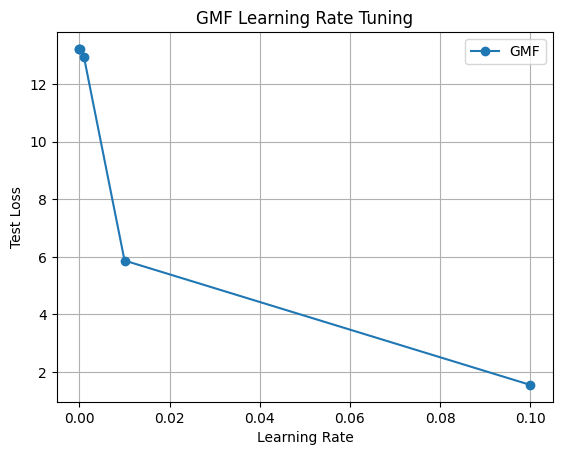

In [ ]:
lr = [0.000001,0.00001,0.0001,0.001,0.01,0.1]
lr_losses1 = []

for l in lr:
  model = GMF(num_users, num_items, emb_size=100)
  print("The learning rate is:",l)
  loss = train_epocs(model, epochs=10, lr=l, wd = 0)
  lr_losses1.append(loss)

plt.plot(lr, lr_losses1, marker='o', label='GMF')
plt.title('GMF Learning Rate Tuning')
plt.xlabel('Learning Rate')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

The learning rate is: 0.001
The test MSE loss is 12.95 
The learning rate is: 0.005
The test MSE loss is 10.56 
The learning rate is: 0.01
The test MSE loss is 5.86 
The learning rate is: 0.05
The test MSE loss is 1.83 
The learning rate is: 0.1
The test MSE loss is 1.53 
The learning rate is: 0.15
The test MSE loss is 13.45 


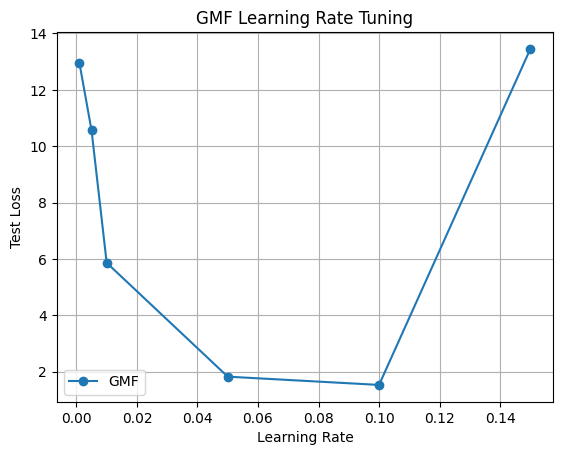

In [ ]:
lr2 = [0.001,0.005,0.01,0.05,0.1,0.15]
lr_losses2 = []

for l in lr2:
  model = GMF(num_users, num_items, emb_size=100)
  print("The learning rate is:",l)
  loss = train_epocs(model, epochs=10, lr=l, wd = 0)
  lr_losses2.append(loss)

plt.plot(lr2, lr_losses2, marker='o', label='GMF')
plt.title('GMF Learning Rate Tuning')
plt.xlabel('Learning Rate')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

The learning rate is: 0.05
The test MSE loss is 1.83 
The learning rate is: 0.06
The test MSE loss is 2.62 
The learning rate is: 0.07
The test MSE loss is 2.29 
The learning rate is: 0.08
The test MSE loss is 1.47 
The learning rate is: 0.09
The test MSE loss is 1.16 
The learning rate is: 0.1
The test MSE loss is 1.54 
The learning rate is: 0.11
The test MSE loss is 1.59 
The learning rate is: 0.12
The test MSE loss is 1.65 


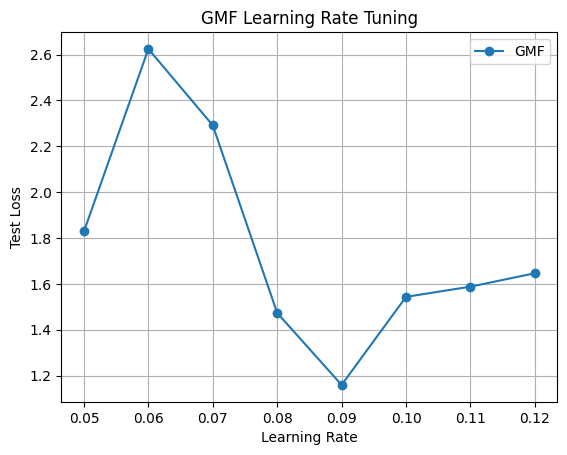

In [ ]:
lr3 = [0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12]
lr_losses3 = []

for l in lr3:
  model = GMF(num_users, num_items, emb_size=100)
  print("The learning rate is:",l)
  loss = train_epocs(model, epochs=10, lr=l, wd = 0)
  lr_losses3.append(loss)

plt.plot(lr3, lr_losses3, marker='o', label='GMF')
plt.title('GMF Learning Rate Tuning')
plt.xlabel('Learning Rate')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

Tuning Weight Decay

The weight decay is: 1e-06
The test MSE loss is 1.15 
The weight decay is: 1e-05
The test MSE loss is 1.12 
The weight decay is: 0.0001
The test MSE loss is 1.18 
The weight decay is: 0.001
The test MSE loss is 3.16 
The weight decay is: 0.01
The test MSE loss is 13.78 
The weight decay is: 0.1
The test MSE loss is 13.04 


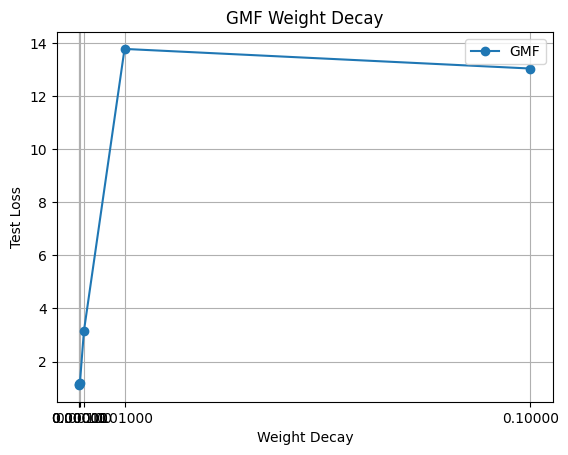

In [ ]:
#from the above learning rate tuning, the best learning rate is 0.09
GMF_wd_list = [0.000001,0.00001,0.0001, 0.001, 0.01, 0.1]
GMF_wd_list_loss = []
for w in GMF_wd_list:
  model = GMF(num_users, num_items, emb_size=100)
  print("The weight decay is:",w)
  loss = train_epocs(model, epochs=10, lr=0.09, wd = w)
  GMF_wd_list_loss.append(loss)

plt.plot(GMF_wd_list, GMF_wd_list_loss, marker='o', label='GMF')
plt.title('GMF Weight Decay')
plt.xlabel('Weight Decay')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.xticks(GMF_wd_list)
plt.show()

The weight decay is: 1e-06
The test MSE loss is 1.15 
The weight decay is: 2e-06
The test MSE loss is 1.15 
The weight decay is: 3e-06
The test MSE loss is 1.14 
The weight decay is: 4e-06
The test MSE loss is 1.14 
The weight decay is: 5e-06
The test MSE loss is 1.14 
The weight decay is: 6e-06
The test MSE loss is 1.13 
The weight decay is: 7e-06
The test MSE loss is 1.13 
The weight decay is: 8e-06
The test MSE loss is 1.12 
The weight decay is: 9e-06
The test MSE loss is 1.12 
The weight decay is: 1e-05
The test MSE loss is 1.12 
The weight decay is: 2e-05
The test MSE loss is 1.10 
The weight decay is: 3e-05
The test MSE loss is 1.10 
The weight decay is: 4e-05
The test MSE loss is 1.10 
The weight decay is: 5e-05
The test MSE loss is 1.10 
The weight decay is: 6e-05
The test MSE loss is 1.11 
The weight decay is: 7e-05
The test MSE loss is 1.12 
The weight decay is: 8e-05
The test MSE loss is 1.14 
The weight decay is: 9e-05
The test MSE loss is 1.16 
The weight decay is: 0.0001


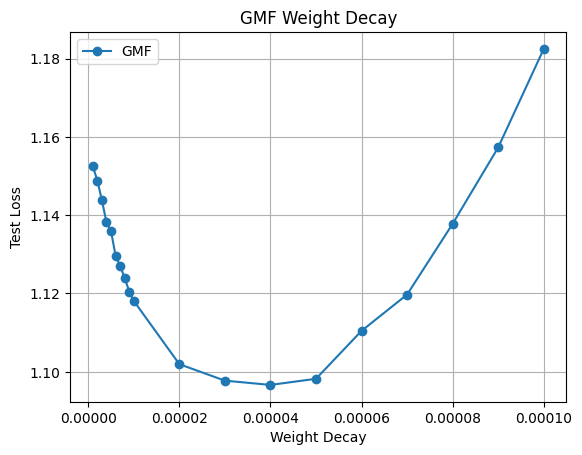

In [ ]:
#from the above learning rate tuning, the best learning rate is 0.09
GMF_wd_list2 = [0.000001,0.000002,0.000003,0.000004,0.000005,0.000006,0.000007,0.000008,0.000009,0.00001,0.00002,0.00003,0.00004,0.00005,0.00006,0.00007,0.00008,0.00009,0.0001]
GMF_wd_list_loss2 = []
for w in GMF_wd_list2:
  model = GMF(num_users, num_items, emb_size=100)
  print("The weight decay is:",w)
  loss = train_epocs(model, epochs=10, lr=0.09, wd = w)
  GMF_wd_list_loss2.append(loss)

plt.plot(GMF_wd_list2, GMF_wd_list_loss2, marker='o', label='GMF')
plt.title('GMF Weight Decay')
plt.xlabel('Weight Decay')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)

plt.show()

Tuning Embedding Size

The test MSE loss is 2.74 
The test MSE loss is 1.10 
The test MSE loss is 1.40 
The test MSE loss is 2.99 
The test MSE loss is 13.17 
The test MSE loss is 13.44 
The test MSE loss is 3.32 
The test MSE loss is 1.30 
The test MSE loss is 1.55 
The test MSE loss is 1.88 
The test MSE loss is 3.58 
The test MSE loss is 3.39 
The test MSE loss is 2.31 
The test MSE loss is 4.91 
The test MSE loss is 6.73 


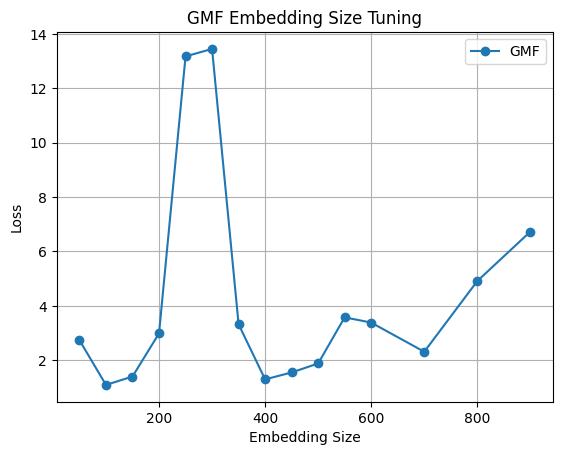

In [ ]:
#from the above, the best learning rate is 0.09 and the weight decay is 0.00004
emb_size = [50,100,150,200,250,300,350,400,450,500,550,600,700,800,900]
GMF_losses1 = []
for size in emb_size:
  model = GMF(num_users, num_items, emb_size=size)
  loss = train_epocs(model,epochs = 10, lr = 0.09, wd = 0.00004)
  GMF_losses1.append(loss)

plt.plot(emb_size, GMF_losses1, marker='o', label='GMF')
plt.title('GMF Embedding Size Tuning')
plt.xlabel('Embedding Size')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

The test MSE loss is 2.74 
The test MSE loss is 2.44 
The test MSE loss is 1.77 
The test MSE loss is 1.41 
The test MSE loss is 1.10 
The test MSE loss is 0.97 
The test MSE loss is 1.42 
The test MSE loss is 1.86 
The test MSE loss is 1.63 
The test MSE loss is 1.41 
The test MSE loss is 1.48 
The test MSE loss is 1.78 
The test MSE loss is 2.21 
The test MSE loss is 2.99 


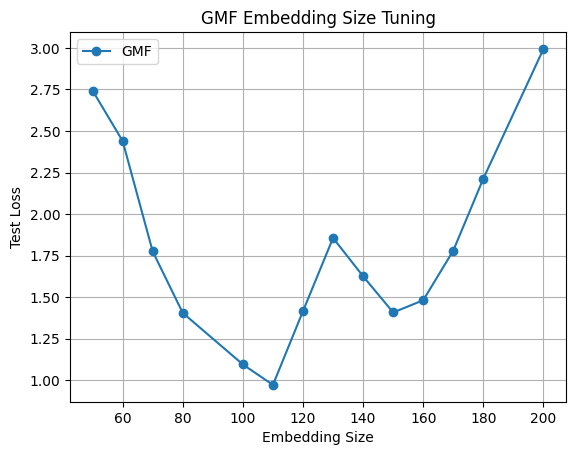

In [ ]:
emb_size2 = [50,60,70,80,100,110,120,130,140,150,160,170,180,200]
GMF_losses2 = []
for size in emb_size2:
  model = GMF(num_users, num_items, emb_size=size)
  loss = train_epocs(model,epochs = 10, lr = 0.09, wd = 0.00004)
  GMF_losses2.append(loss)

plt.plot(emb_size2, GMF_losses2, marker='o', label='GMF')
plt.title('GMF Embedding Size Tuning')
plt.xlabel('Embedding Size')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

The test MSE loss is 0.99 
The test MSE loss is 0.98 
The test MSE loss is 0.97 
The test MSE loss is 0.96 
The test MSE loss is 0.97 
The test MSE loss is 0.97 
The test MSE loss is 0.99 
The test MSE loss is 1.01 
The test MSE loss is 1.03 
The test MSE loss is 1.07 
The test MSE loss is 1.12 


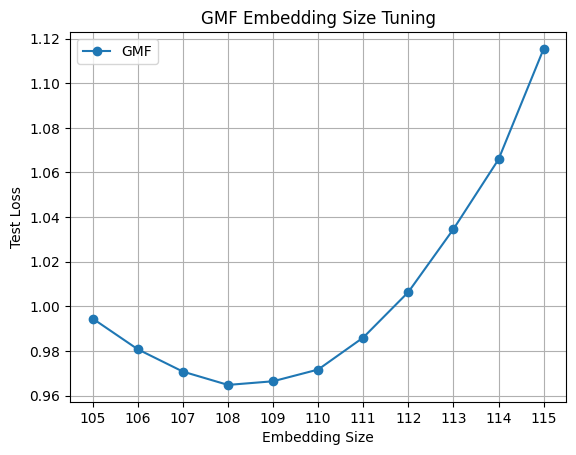

In [ ]:
emb_size3 = [105,106,107,108,109,110,111,112,113,114,115]
GMF_losses3 = []
for size in emb_size3:
  model = GMF(num_users, num_items, emb_size=size)
  loss = train_epocs(model,epochs = 10, lr = 0.09, wd = 0.00004)
  GMF_losses3.append(loss)

plt.plot(emb_size3, GMF_losses3, marker='o', label='GMF')
plt.title('GMF Embedding Size Tuning')
plt.xlabel('Embedding Size')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.xticks(emb_size3)
plt.show()

Tuning Number of Epochs

The test MSE loss is 0.97 
The test MSE loss is 0.84 
The test MSE loss is 0.85 
The test MSE loss is 0.86 
The test MSE loss is 0.82 
The test MSE loss is 0.84 
The test MSE loss is 0.89 
The test MSE loss is 0.94 
The test MSE loss is 0.98 
The test MSE loss is 1.00 


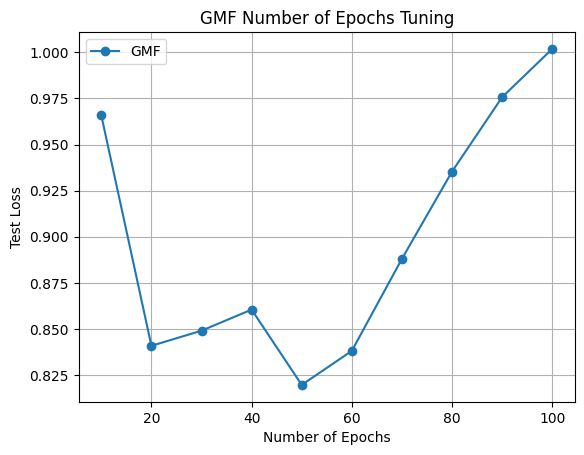

In [ ]:
# from the tunning above, the best learning rate = 0.09, weight decay = 0.00004, embedding size = 108
num_epochs = [10,20,30,40,50,60,70,80,90,100]
epoch_losses = []

for num in num_epochs:
  model = GMF(num_users, num_items, emb_size=108)
  loss = train_epocs(model,epochs = num, lr = 0.09, wd = 0.00004)
  epoch_losses.append(loss)

plt.plot(num_epochs, epoch_losses, marker='o', label='GMF')
plt.title('GMF Number of Epochs Tuning')
plt.xlabel('Number of Epochs')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

The test MSE loss is 0.84 
The test MSE loss is 0.88 
The test MSE loss is 0.85 
The test MSE loss is 0.90 
The test MSE loss is 0.86 
The test MSE loss is 0.84 
The test MSE loss is 0.82 
The test MSE loss is 0.83 
The test MSE loss is 0.85 


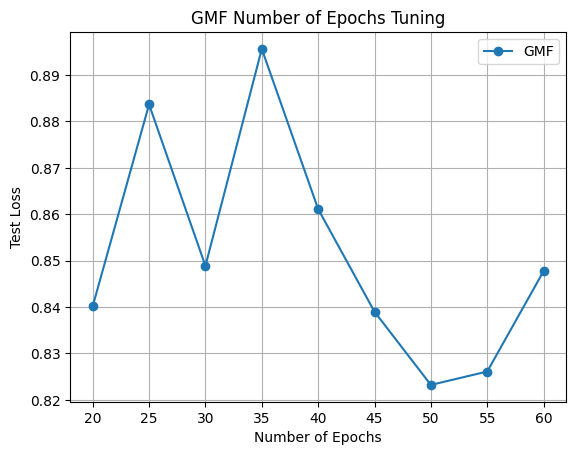

In [ ]:
num_epochs2 = [20,25,30,35,40,45,50,55,60]
epoch_losses2 = []

for num in num_epochs2:
  model = GMF(num_users, num_items, emb_size=108)
  loss = train_epocs(model,epochs = num, lr = 0.09, wd = 0.00004)
  epoch_losses2.append(loss)

plt.plot(num_epochs2, epoch_losses2, marker='o', label='GMF')
plt.title('GMF Number of Epochs Tuning')
plt.xlabel('Number of Epochs')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

The test MSE loss is 0.82 
The test MSE loss is 0.84 
The test MSE loss is 0.84 
The test MSE loss is 0.82 
The test MSE loss is 0.81 
The test MSE loss is 0.82 
The test MSE loss is 0.83 
The test MSE loss is 0.83 
The test MSE loss is 0.84 
The test MSE loss is 0.86 
The test MSE loss is 0.84 


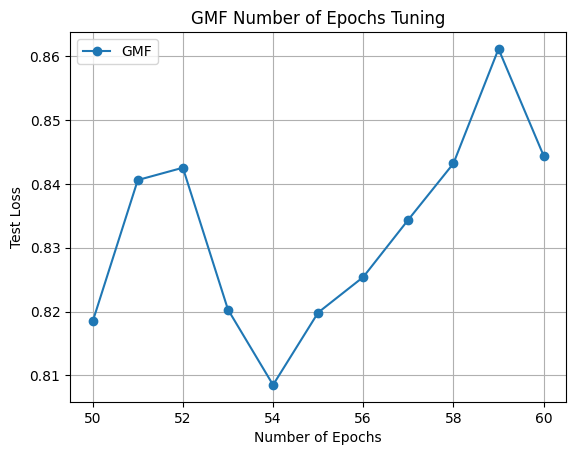

In [ ]:
num_epochs3 = [50,51,52,53,54,55,56,57,58,59,60]
epoch_losses3 = []

for num in num_epochs3:
  model = GMF(num_users, num_items, emb_size=108)
  loss = train_epocs(model,epochs = num, lr = 0.09, wd = 0.00004)
  epoch_losses3.append(loss)

plt.plot(num_epochs3, epoch_losses3, marker='o', label='GMF')
plt.title('GMF Number of Epochs Tuning')
plt.xlabel('Number of Epochs')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

According to the evaluation above, the best setting for GMF is learning rate = 0.09, weight decay = 0.00004, embedding size = 108

# **MLP**

In [ ]:

class MLP(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, hidden_size=10):
        super(MLP, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)
        self.fc1 = nn.Linear(emb_size * 2,hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size,1)
        self.drop = nn.Dropout(0.1)
    def forward(self, u, v):
        u = self.user_emb(u)
        v = self.item_emb(v)
        x = torch.cat([u,v],dim = 1)
        x = self.drop(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x.squeeze()


Baseline model

In [ ]:
model_train = MLP(num_users, num_items)
train_epocs(model_train, epochs=10, lr=0.1)

The test MSE loss is 1.14 


1.143683671951294

Hyperparameter Tuning

Learning Rate Tuning

The learning rate is: 1e-06
The test MSE loss is 12.72 
The learning rate is: 1e-05
The test MSE loss is 12.26 
The learning rate is: 0.0001
The test MSE loss is 12.32 
The learning rate is: 0.001
The test MSE loss is 10.85 
The learning rate is: 0.01
The test MSE loss is 7.87 
The learning rate is: 0.1
The test MSE loss is 1.15 
The learning rate is: 0.9
The test MSE loss is 2.73 


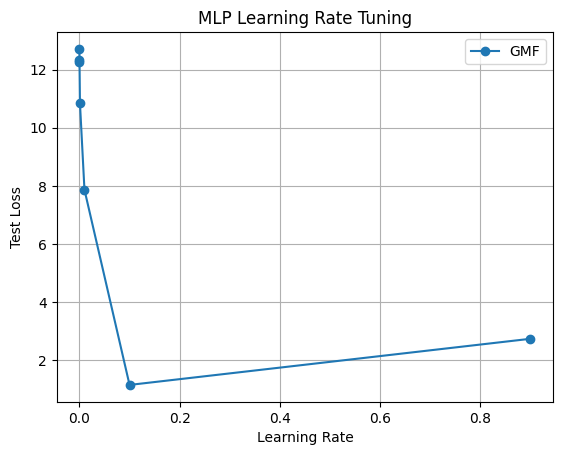

In [ ]:
lr = [0.000001,0.00001,0.0001,0.001,0.01,0.1,0.9]
lr_losses1 = []

for l in lr:
  model = MLP(num_users, num_items, emb_size=100)
  print("The learning rate is:",l)
  loss = train_epocs(model, epochs=10, lr=l, wd = 0)
  lr_losses1.append(loss)

plt.plot(lr, lr_losses1, marker='o', label='GMF')
plt.title('MLP Learning Rate Tuning')
plt.xlabel('Learning Rate')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

The learning rate is: 0.05
The test MSE loss is 1.10 
The learning rate is: 0.06
The test MSE loss is 1.50 
The learning rate is: 0.07
The test MSE loss is 1.40 
The learning rate is: 0.08
The test MSE loss is 1.13 
The learning rate is: 0.09
The test MSE loss is 0.85 
The learning rate is: 0.1
The test MSE loss is 1.05 
The learning rate is: 0.11
The test MSE loss is 1.27 
The learning rate is: 0.12
The test MSE loss is 1.17 
The learning rate is: 0.13
The test MSE loss is 1.43 
The learning rate is: 0.14
The test MSE loss is 11.56 
The learning rate is: 0.15
The test MSE loss is 1.38 


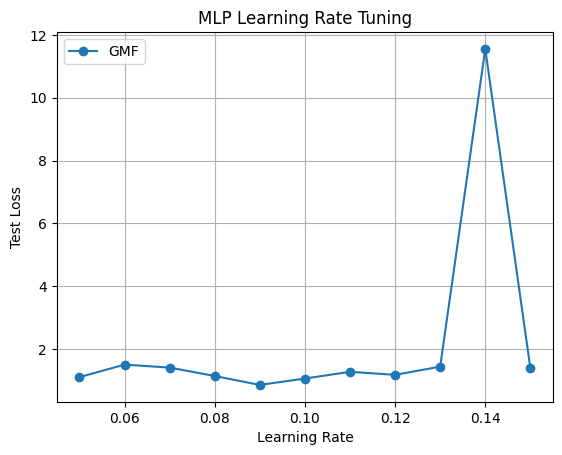

In [ ]:
MLP_lr2 = [0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15]
MLP_lr_losses2 = []

for l in MLP_lr2:
  model = MLP(num_users, num_items, emb_size=100)
  print("The learning rate is:",l)
  loss = train_epocs(model, epochs=10, lr=l, wd = 0)
  MLP_lr_losses2.append(loss)

plt.plot(MLP_lr2, MLP_lr_losses2, marker='o', label='GMF')
plt.title('MLP Learning Rate Tuning')
plt.xlabel('Learning Rate')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

Hidden Layer Size Tuning

The current hidden layer size is: 10
The test MSE loss is 2.29 
The current hidden layer size is: 20
The test MSE loss is 0.96 
The current hidden layer size is: 30
The test MSE loss is 1.13 
The current hidden layer size is: 40
The test MSE loss is 3.78 
The current hidden layer size is: 50
The test MSE loss is 17.40 
The current hidden layer size is: 60
The test MSE loss is 1.37 
The current hidden layer size is: 70
The test MSE loss is 1.96 
The current hidden layer size is: 80
The test MSE loss is 5.77 
The current hidden layer size is: 90
The test MSE loss is 1.08 
The current hidden layer size is: 100
The test MSE loss is 8.78 
The current hidden layer size is: 200
The test MSE loss is 9.00 


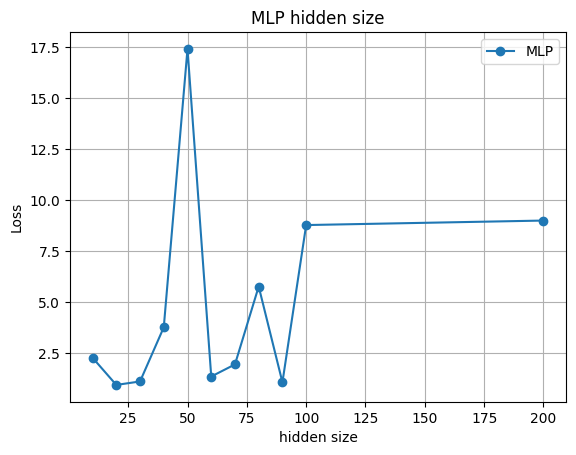

In [ ]:
# the best lr = 0.09
MLP_hid_list = [10,20,30,40,50,60,70,80,90,100,200]
MLP_hid_list_loss = []

for i in MLP_hid_list:
  model = MLP(num_users, num_items, hidden_size = i)
  print("The current hidden layer size is:",i)
  MLP_hid_list_loss.append(train_epocs(model, epochs=10, lr=0.09, wd = 0))

plt.plot(MLP_hid_list, MLP_hid_list_loss, marker='o', label='MLP')
plt.title('MLP hidden size')
plt.xlabel('hidden size')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The current hidden layer size is: 20
The test MSE loss is 2.39 
The current hidden layer size is: 25
The test MSE loss is 10.37 
The current hidden layer size is: 30
The test MSE loss is 0.84 
The current hidden layer size is: 35
The test MSE loss is 10.45 
The current hidden layer size is: 40
The test MSE loss is 51.58 
The current hidden layer size is: 45
The test MSE loss is 1.57 
The current hidden layer size is: 50
The test MSE loss is 2.93 
The current hidden layer size is: 55
The test MSE loss is 5.22 
The current hidden layer size is: 60
The test MSE loss is 1.40 
The current hidden layer size is: 65
The test MSE loss is 20.53 
The current hidden layer size is: 70
The test MSE loss is 4.41 
The current hidden layer size is: 75
The test MSE loss is 21.53 
The current hidden layer size is: 80
The test MSE loss is 11.42 


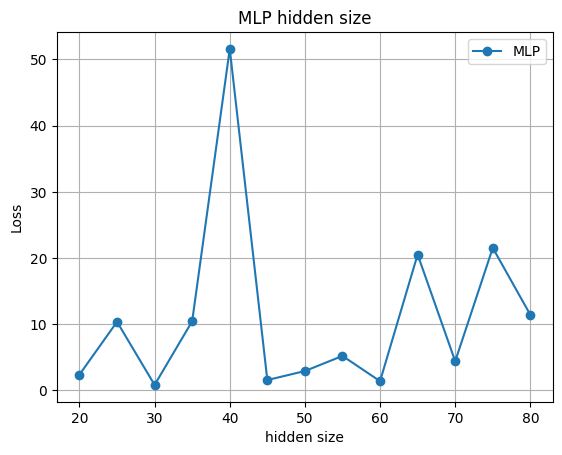

In [ ]:
MLP_hid_list2 = [20,25,30,35,40,45,50,55,60,65,70,75,80]
MLP_hid_list_loss2 = []

for i in MLP_hid_list2:
  model = MLP(num_users, num_items, hidden_size = i)
  print("The current hidden layer size is:",i)
  MLP_hid_list_loss2.append(train_epocs(model, epochs=10, lr=0.09, wd = 0))

plt.plot(MLP_hid_list2, MLP_hid_list_loss2, marker='o', label='MLP')
plt.title('MLP hidden size')
plt.xlabel('hidden size')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Embedding Size Tuning

The current emb size is: 50
The test MSE loss is 0.86 
The current emb size is: 100
The test MSE loss is 9.07 
The current emb size is: 150
The test MSE loss is 9.57 
The current emb size is: 200
The test MSE loss is 1.27 
The current emb size is: 250
The test MSE loss is 2.38 
The current emb size is: 300
The test MSE loss is 14.62 


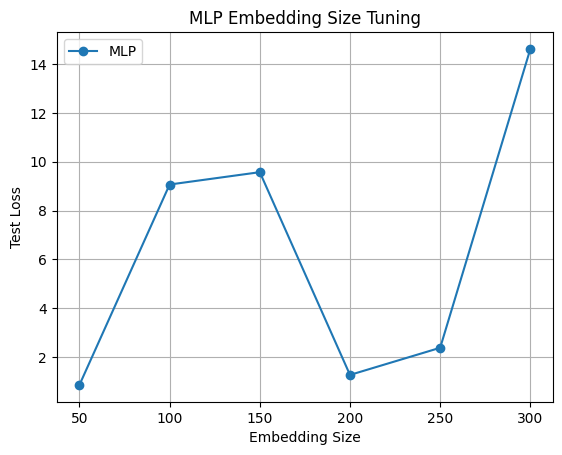

In [ ]:
# the best lr = 0.09, the best hidden layer size = 30
MLP_emb_list = [50, 100, 150, 200, 250, 300]
MLP_emb_list_loss = []
for i in MLP_emb_list:
  model = MLP(num_users, num_items, emb_size = i, hidden_size = 30)
  print("The current emb size is:",i)
  MLP_emb_list_loss.append(train_epocs(model, epochs=10, lr=0.09, wd = 0))

plt.plot(MLP_emb_list, MLP_emb_list_loss, marker='o', label='MLP')
plt.title('MLP Embedding Size Tuning')
plt.xlabel('Embedding Size')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

The current emb size is: 10
The test MSE loss is 0.98 
The current emb size is: 20
The test MSE loss is 1.70 
The current emb size is: 30
The test MSE loss is 1.00 
The current emb size is: 40
The test MSE loss is 1.43 
The current emb size is: 50
The test MSE loss is 0.84 
The current emb size is: 60
The test MSE loss is 1.22 
The current emb size is: 70
The test MSE loss is 3.83 
The current emb size is: 80
The test MSE loss is 1.93 
The current emb size is: 90
The test MSE loss is 2.57 
The current emb size is: 100
The test MSE loss is 2.74 


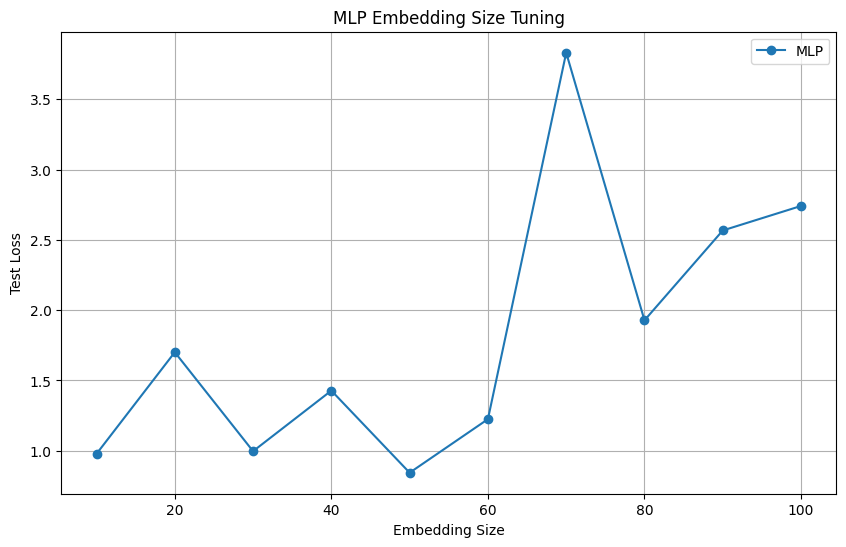

In [ ]:
MLP_emb_list2 = [10,20,30,40,50,60,70,80,90,100]
MLP_emb_list_loss2 = []
for i in MLP_emb_list2:
  model = MLP(num_users, num_items, emb_size = i, hidden_size = 30)
  print("The current emb size is:",i)
  MLP_emb_list_loss2.append(train_epocs(model, epochs=10, lr=0.09, wd = 0))

plt.figure(figsize=(10, 6))
plt.plot(MLP_emb_list2, MLP_emb_list_loss2, marker='o', label='MLP')
plt.title('MLP Embedding Size Tuning')
plt.xlabel('Embedding Size')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

The current emb size is: 40
The test MSE loss is 1.27 
The current emb size is: 41
The test MSE loss is 0.86 
The current emb size is: 42
The test MSE loss is 2.38 
The current emb size is: 43
The test MSE loss is 1.29 
The current emb size is: 44
The test MSE loss is 1.26 
The current emb size is: 45
The test MSE loss is 1.09 
The current emb size is: 46
The test MSE loss is 1.84 
The current emb size is: 47
The test MSE loss is 0.79 
The current emb size is: 48
The test MSE loss is 0.88 
The current emb size is: 49
The test MSE loss is 2.94 
The current emb size is: 50
The test MSE loss is 1.04 
The current emb size is: 51
The test MSE loss is 3.30 
The current emb size is: 52
The test MSE loss is 2.42 
The current emb size is: 53
The test MSE loss is 1.78 
The current emb size is: 54
The test MSE loss is 0.91 
The current emb size is: 55
The test MSE loss is 1.17 
The current emb size is: 56
The test MSE loss is 1.15 
The current emb size is: 57
The test MSE loss is 1.14 
The curren

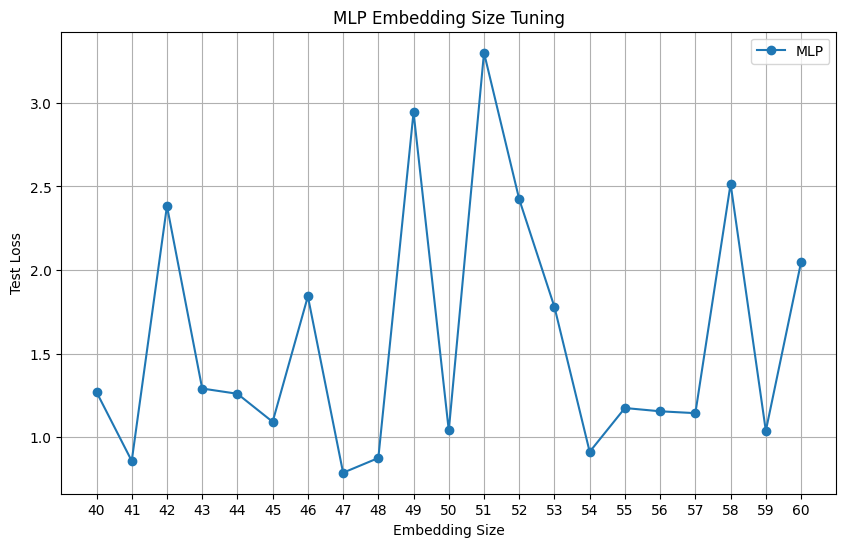

In [ ]:
MLP_emb_list3 = [40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60]
MLP_emb_list_loss3 = []
for i in MLP_emb_list3:
  model = MLP(num_users, num_items, emb_size = i, hidden_size = 30)
  print("The current emb size is:",i)
  MLP_emb_list_loss3.append(train_epocs(model, epochs=10, lr=0.09, wd = 0))

plt.figure(figsize=(10, 6))
plt.plot(MLP_emb_list3, MLP_emb_list_loss3, marker='o', label='MLP')
plt.title('MLP Embedding Size Tuning')
plt.xlabel('Embedding Size')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.xticks(MLP_emb_list3)
plt.show()

Weight Decay Tuning:

The weight decay is: 1e-06
The test MSE loss is 0.98 
The weight decay is: 1e-05
The test MSE loss is 0.90 
The weight decay is: 0.0001
The test MSE loss is 4.64 
The weight decay is: 0.001
The test MSE loss is 1.27 
The weight decay is: 0.01
The test MSE loss is 1.37 


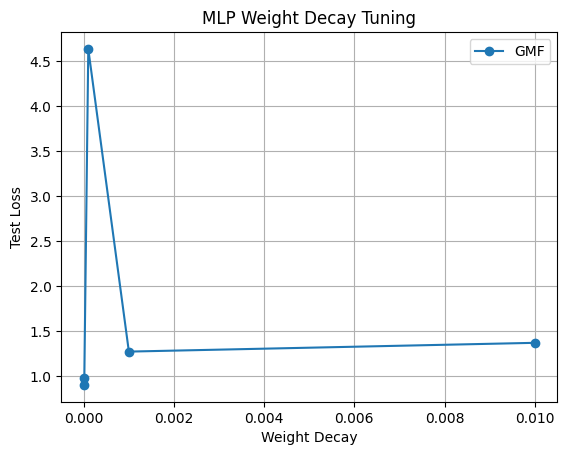

In [ ]:
#the best learning rate from above is 0.09, hidden layer size = 30, embedding size = 47
MLP_weights = [0.000001,0.00001,0.0001, 0.001, 0.01]
MLP_weights_losses = []

for w in MLP_weights:
  model = MLP(num_users, num_items, emb_size = 47, hidden_size = 30)
  print("The weight decay is:",w)
  loss = train_epocs(model, epochs=10, lr=0.09, wd = w)
  MLP_weights_losses.append(loss)

plt.plot(MLP_weights, MLP_weights_losses, marker='o', label='GMF')
plt.title('MLP Weight Decay Tuning')
plt.xlabel('Weight Decay')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)

plt.show()

The weight decay is: 1e-06
The test MSE loss is 1.04 
The weight decay is: 2e-06
The test MSE loss is 2.59 
The weight decay is: 4e-06
The test MSE loss is 1.06 
The weight decay is: 6e-06
The test MSE loss is 0.88 
The weight decay is: 8e-06
The test MSE loss is 0.99 
The weight decay is: 1e-05
The test MSE loss is 1.14 


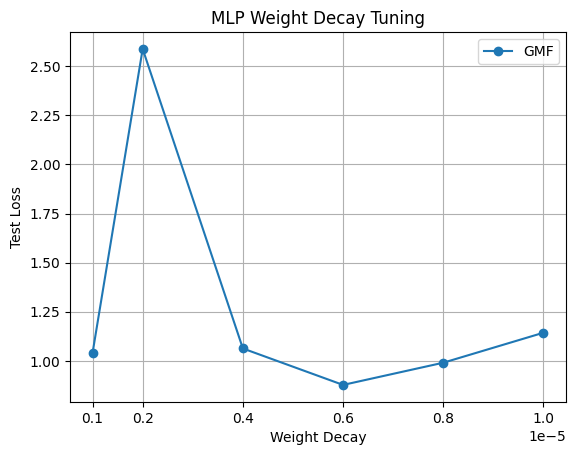

In [ ]:
MLP_weights2 = [0.000001,0.000002,0.000004,0.000006,0.000008,0.00001]
MLP_weights_losses2 = []

for w in MLP_weights2:
  model = MLP(num_users, num_items, emb_size = 47, hidden_size = 30)
  print("The weight decay is:",w)
  loss = train_epocs(model, epochs=10, lr=0.09, wd = w)
  MLP_weights_losses2.append(loss)

plt.plot(MLP_weights2, MLP_weights_losses2, marker='o', label='GMF')
plt.title('MLP Weight Decay Tuning')
plt.xlabel('Weight Decay')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.xticks(MLP_weights2)
plt.show()

Number of Epochs Tuning:

The number of epochs is 10
The test MSE loss is 2.20 
The number of epochs is 20
The test MSE loss is 0.87 
The number of epochs is 30
The test MSE loss is 0.81 
The number of epochs is 40
The test MSE loss is 0.80 
The number of epochs is 50
The test MSE loss is 0.76 
The number of epochs is 60
The test MSE loss is 0.81 
The number of epochs is 70
The test MSE loss is 0.78 
The number of epochs is 80
The test MSE loss is 0.81 
The number of epochs is 90
The test MSE loss is 0.81 
The number of epochs is 100
The test MSE loss is 0.77 


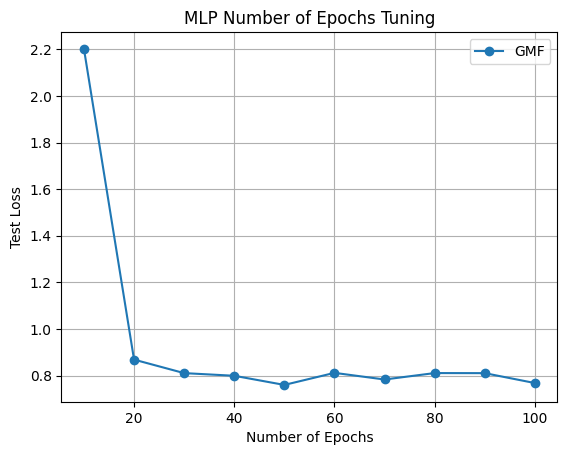

In [ ]:
# the best lr = 0.09, hidden layer size = 30, embedding size = 47, weight decay = 0.000006

MLP_epochs = [10,20,30,40,50,60,70,80,90,100]
MLP_epochs_losses = []

for i in MLP_epochs:
  model = MLP(num_users, num_items, emb_size = 47, hidden_size = 30)
  print("The number of epochs is",i)
  loss = train_epocs(model, epochs=i, lr=0.09, wd = 0.000006)
  MLP_epochs_losses.append(loss)

plt.plot(MLP_epochs, MLP_epochs_losses, marker='o', label='GMF')
plt.title('MLP Number of Epochs Tuning')
plt.xlabel('Number of Epochs')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

The number of epochs is 40
The test MSE loss is 0.78 
The number of epochs is 45
The test MSE loss is 0.77 
The number of epochs is 50
The test MSE loss is 0.77 
The number of epochs is 55
The test MSE loss is 0.80 
The number of epochs is 60
The test MSE loss is 0.78 


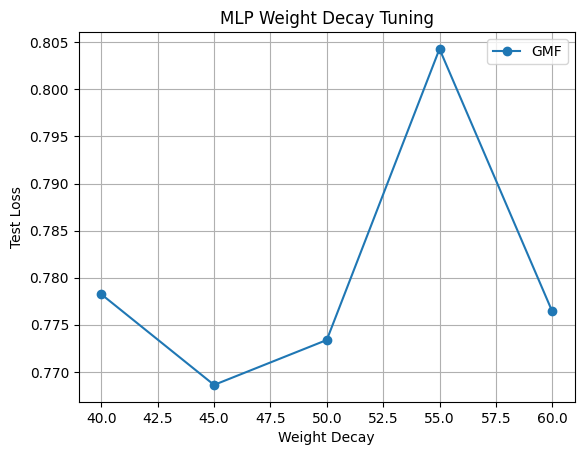

In [ ]:
MLP_epochs2 = [40,45,50,55,60]
MLP_epochs_losses2 = []

for i in MLP_epochs2:
  model = MLP(num_users, num_items, emb_size = 47, hidden_size = 30)
  print("The number of epochs is",i)
  loss = train_epocs(model, epochs=i, lr=0.09, wd = 0.000006)
  MLP_epochs_losses2.append(loss)

plt.plot(MLP_epochs2, MLP_epochs_losses2, marker='o', label='GMF')
plt.title('MLP Weight Decay Tuning')
plt.xlabel('Weight Decay')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

the best lr = 0.09, hidden layer size = 30, embedding size = 47, weight decay = 0.000006 and the number of training epochs is 45

# **NeuMF**

In [ ]:
class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, hidden_size=10, final_size = 5):
        super(NeuMF, self).__init__()
        self.user_emb_GMF = nn.Embedding(num_users, emb_size)
        self.item_emb_GMF = nn.Embedding(num_items, emb_size)
        self.user_emb_MLP = nn.Embedding(num_users, emb_size)
        self.item_emb_MLP = nn.Embedding(num_items, emb_size)
        self.user_emb_MLP.weight.data.uniform_(0, 0.05)
        self.item_emb_MLP.weight.data.uniform_(0, 0.05)
        self.fc1 = nn.Linear(emb_size * 2, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, final_size)
        self.drop = nn.Dropout(0.1) #drop out neruons to prevent overfitting
        self.prediction = nn.Linear(emb_size + final_size,1)
    def forward(self, u, v):
        u_M = self.user_emb_MLP(u)
        v_M = self.item_emb_MLP(v)
        x_M = torch.cat([u_M,v_M],dim = 1)
        x_M = self.drop(x_M)
        x_M = self.fc1(x_M)
        x_M = self.relu(x_M)
        x_M = self.fc2(x_M)


        u_G = self.user_emb_GMF(u)
        v_G = self.item_emb_GMF(v)
        x_G = (u_G * v_G)

        x = torch.cat([x_M,x_G], dim = 1)
        x = self.prediction(x)
        return x.squeeze()

baseline model

In [ ]:
model_NeuMF = NeuMF(num_users, num_items)
train_epocs(model_NeuMF, epochs=10, lr=0.1)

The test MSE loss is 3.55 


3.551438570022583

Hyperparameter Tuning

Learning Rate Tuning

The learning rate is: 1e-06
The test MSE loss is 13.28 
The learning rate is: 1e-05
The test MSE loss is 14.13 
The learning rate is: 0.0001
The test MSE loss is 13.44 
The learning rate is: 0.001
The test MSE loss is 13.60 
The learning rate is: 0.01
The test MSE loss is 10.02 
The learning rate is: 0.1
The test MSE loss is 9.55 
The learning rate is: 0.9
The test MSE loss is 914464.38 


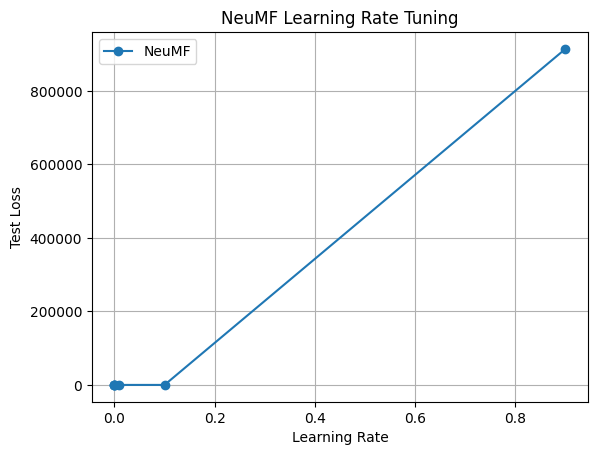

In [ ]:
NeuMF_lr = [0.000001,0.00001,0.0001,0.001,0.01,0.1,0.9]
Neu_MF_lr_losses1 = []

for l in NeuMF_lr:
  model = NeuMF(num_users, num_items, emb_size=100,hidden_size=10, final_size = 5)
  print("The learning rate is:",l)
  loss = train_epocs(model, epochs=10, lr=l, wd = 0)
  Neu_MF_lr_losses1.append(loss)

plt.plot(NeuMF_lr, Neu_MF_lr_losses1, marker='o', label='NeuMF')
plt.title('NeuMF Learning Rate Tuning')
plt.xlabel('Learning Rate')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

The learning rate is: 0.01
The test MSE loss is 7.31 
The learning rate is: 0.05
The test MSE loss is 4.11 
The learning rate is: 0.1
The test MSE loss is 4.36 
The learning rate is: 0.15
The test MSE loss is 9.84 
The learning rate is: 0.2
The test MSE loss is 12.27 


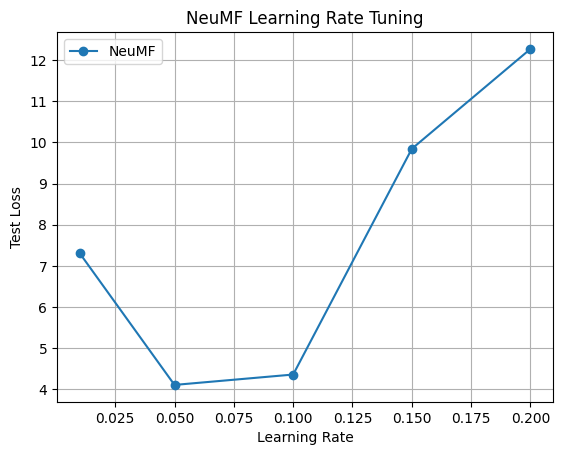

In [ ]:
NeuMF_lr2 = [0.01,0.05,0.1,0.15,0.2]
Neu_MF_lr_losses2 = []

for l in NeuMF_lr2:
  model = NeuMF(num_users, num_items, emb_size=100,hidden_size=10, final_size = 5)
  print("The learning rate is:",l)
  loss = train_epocs(model, epochs=10, lr=l, wd = 0)
  Neu_MF_lr_losses2.append(loss)

plt.plot(NeuMF_lr2, Neu_MF_lr_losses2, marker='o', label='NeuMF')
plt.title('NeuMF Learning Rate Tuning')
plt.xlabel('Learning Rate')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

The learning rate is: 0.01
The test MSE loss is 9.18 
The learning rate is: 0.03
The test MSE loss is 1.67 
The learning rate is: 0.05
The test MSE loss is 3.29 
The learning rate is: 0.07
The test MSE loss is 4.61 
The learning rate is: 0.09
The test MSE loss is 4.01 


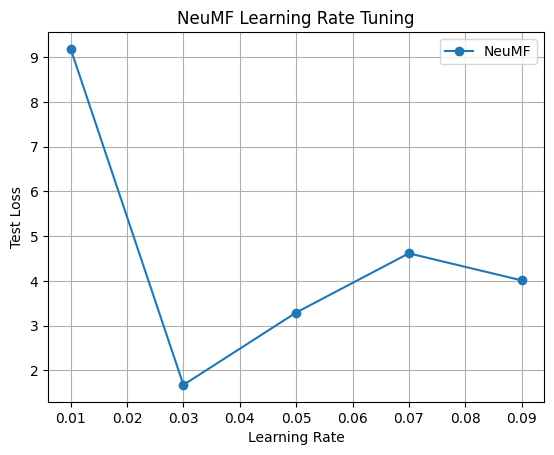

In [ ]:
NeuMF_lr3 = [0.01,0.03,0.05,0.07,0.09]
Neu_MF_lr_losses3 = []

for l in NeuMF_lr3:
  model = NeuMF(num_users, num_items, emb_size=100,hidden_size=10, final_size = 5)
  print("The learning rate is:",l)
  loss = train_epocs(model, epochs=10, lr=l, wd = 0)
  Neu_MF_lr_losses3.append(loss)

plt.plot(NeuMF_lr3, Neu_MF_lr_losses3, marker='o', label='NeuMF')
plt.title('NeuMF Learning Rate Tuning')
plt.xlabel('Learning Rate')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

Hidden Size Tuning

The current hidden layer size is: 5
The test MSE loss is 1.46 
The current hidden layer size is: 10
The test MSE loss is 1.69 
The current hidden layer size is: 20
The test MSE loss is 1.41 
The current hidden layer size is: 30
The test MSE loss is 2.74 
The current hidden layer size is: 40
The test MSE loss is 2.33 
The current hidden layer size is: 50
The test MSE loss is 3.27 
The current hidden layer size is: 60
The test MSE loss is 2.14 
The current hidden layer size is: 70
The test MSE loss is 1.95 
The current hidden layer size is: 80
The test MSE loss is 1.82 
The current hidden layer size is: 90
The test MSE loss is 2.99 
The current hidden layer size is: 100
The test MSE loss is 0.91 
The current hidden layer size is: 200
The test MSE loss is 0.95 


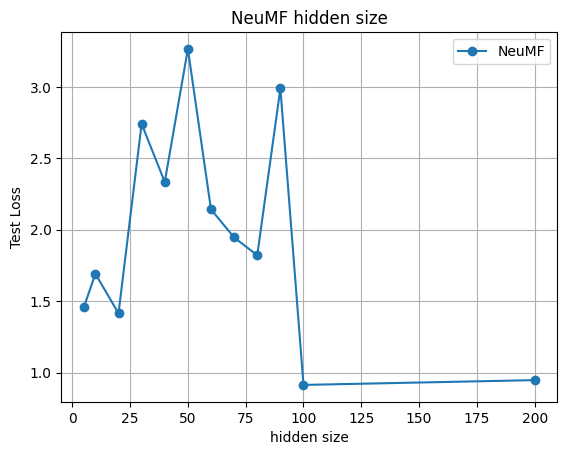

In [ ]:
# the best lr = 0.03
NeuMF_hid_list = [5,10,20,30,40,50,60,70,80,90,100,200]
NeuMF_hid_list_loss = []

for i in NeuMF_hid_list:
  model = NeuMF(num_users, num_items, emb_size=100,hidden_size=i, final_size = 5)
  print("The current hidden layer size is:",i)
  NeuMF_hid_list_loss.append(train_epocs(model, epochs=10, lr=0.03, wd = 0))

plt.plot(NeuMF_hid_list, NeuMF_hid_list_loss, marker='o', label='NeuMF')
plt.title('NeuMF hidden size')
plt.xlabel('hidden size')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

The current hidden layer size is: 80
The test MSE loss is 0.89 
The current hidden layer size is: 85
The test MSE loss is 0.87 
The current hidden layer size is: 90
The test MSE loss is 2.63 
The current hidden layer size is: 95
The test MSE loss is 0.92 
The current hidden layer size is: 100
The test MSE loss is 3.90 
The current hidden layer size is: 105
The test MSE loss is 7.05 
The current hidden layer size is: 110
The test MSE loss is 6.81 


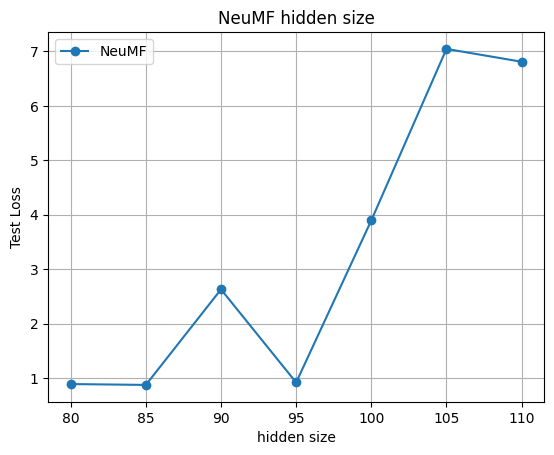

In [ ]:
NeuMF_hid_list2 = [80,85,90,95,100,105,110]
NeuMF_hid_list_loss2 = []

for i in NeuMF_hid_list2:
  model = NeuMF(num_users, num_items, emb_size=100,hidden_size=i, final_size = 5)
  print("The current hidden layer size is:",i)
  NeuMF_hid_list_loss2.append(train_epocs(model, epochs=10, lr=0.03, wd = 0))

plt.plot(NeuMF_hid_list2, NeuMF_hid_list_loss2, marker='o', label='NeuMF')
plt.title('NeuMF hidden size')
plt.xlabel('hidden size')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

Embedding Size Tuning

The current emb size is: 50
The test MSE loss is 3.28 
The current emb size is: 100
The test MSE loss is 5.15 
The current emb size is: 150
The test MSE loss is 6.58 
The current emb size is: 200
The test MSE loss is 9.68 
The current emb size is: 250
The test MSE loss is 0.92 
The current emb size is: 300
The test MSE loss is 1.19 


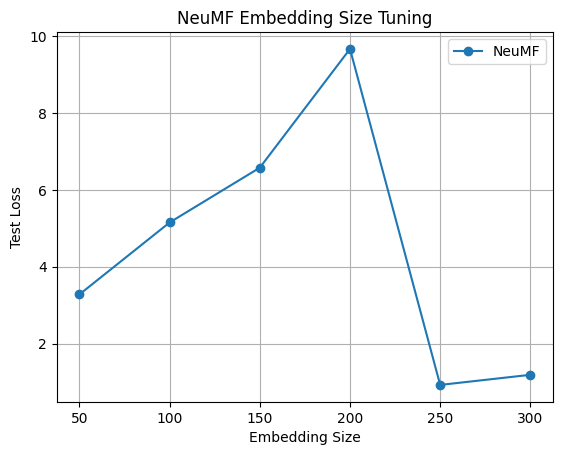

In [ ]:
# the best lr = 0.03, the best hidden layer size = 85
NeuMF_emb_list = [50, 100, 150, 200, 250, 300]
NeuMF_emb_list_loss = []
for i in NeuMF_emb_list:
  model = NeuMF(num_users, num_items, emb_size=i,hidden_size=85, final_size = 5)
  print("The current emb size is:",i)
  NeuMF_emb_list_loss.append(train_epocs(model, epochs=10, lr=0.03, wd = 0))

plt.plot(NeuMF_emb_list, NeuMF_emb_list_loss, marker='o', label='NeuMF')
plt.title('NeuMF Embedding Size Tuning')
plt.xlabel('Embedding Size')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

The current emb size is: 200
The test MSE loss is 5.63 
The current emb size is: 210
The test MSE loss is 7.54 
The current emb size is: 220
The test MSE loss is 6.14 
The current emb size is: 230
The test MSE loss is 0.93 
The current emb size is: 240
The test MSE loss is 10.35 
The current emb size is: 250
The test MSE loss is 0.95 
The current emb size is: 260
The test MSE loss is 4.72 
The current emb size is: 270
The test MSE loss is 6.46 
The current emb size is: 280
The test MSE loss is 1.24 
The current emb size is: 290
The test MSE loss is 0.98 
The current emb size is: 300
The test MSE loss is 8.92 


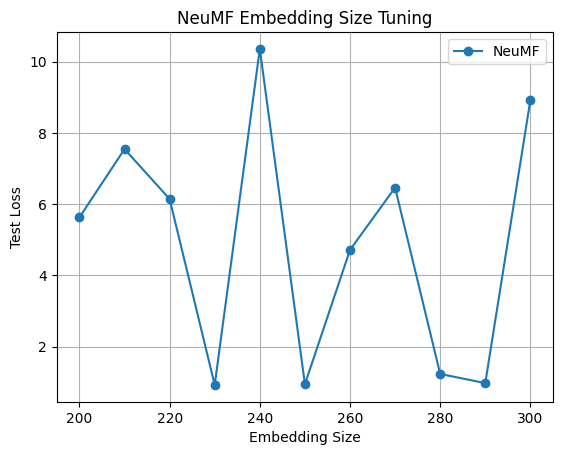

In [ ]:
NeuMF_emb_list2 = [200,210,220,230,240,250,260,270,280,290,300]
NeuMF_emb_list_loss2 = []
for i in NeuMF_emb_list2:
  model = NeuMF(num_users, num_items, emb_size=i,hidden_size=85, final_size = 5)
  print("The current emb size is:",i)
  NeuMF_emb_list_loss2.append(train_epocs(model, epochs=10, lr=0.03, wd = 0))

plt.plot(NeuMF_emb_list2, NeuMF_emb_list_loss2, marker='o', label='NeuMF')
plt.title('NeuMF Embedding Size Tuning')
plt.xlabel('Embedding Size')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

Final Size Tuning

The current final size is: 1
The test MSE loss is 2.27 
The current final size is: 2
The test MSE loss is 1.27 
The current final size is: 3
The test MSE loss is 8.84 
The current final size is: 4
The test MSE loss is 8.51 
The current final size is: 5
The test MSE loss is 2.00 
The current final size is: 6
The test MSE loss is 1.19 
The current final size is: 7
The test MSE loss is 0.95 
The current final size is: 8
The test MSE loss is 4.22 
The current final size is: 9
The test MSE loss is 8.43 
The current final size is: 10
The test MSE loss is 6.61 


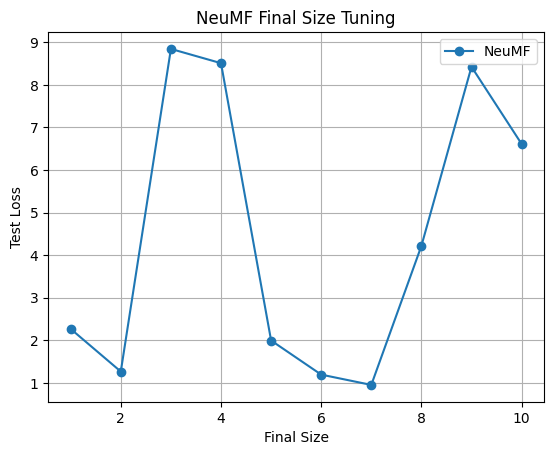

In [ ]:
# the best lr = 0.03, the best hidden layer size = 85, the best embedding size is 250
NeuMF_final_list = [1,2,3,4,5,6,7,8,9,10]
NeuMF_final_list_loss = []
for i in NeuMF_final_list:
  model = NeuMF(num_users, num_items, emb_size=250,hidden_size=85, final_size = i)
  print("The current final size is:",i)
  NeuMF_final_list_loss.append(train_epocs(model, epochs=10, lr=0.03, wd = 0))

plt.plot(NeuMF_final_list, NeuMF_final_list_loss, marker='o', label='NeuMF')
plt.title('NeuMF Final Size Tuning')
plt.xlabel('Final Size')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

Weight Decay Tuning

The weight decay is: 1e-06
The test MSE loss is 1.13 
The weight decay is: 1e-05
The test MSE loss is 1.06 
The weight decay is: 0.0001
The test MSE loss is 0.95 
The weight decay is: 0.001
The test MSE loss is 1.08 
The weight decay is: 0.01
The test MSE loss is 3.09 


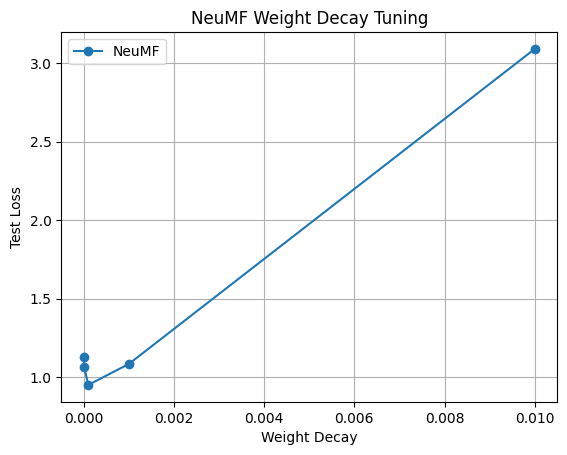

In [ ]:
# the best lr = 0.03, the best hidden layer size = 85, the best embedding size is 250,final size = 7
NeuMF_weights = [0.000001,0.00001,0.0001, 0.001, 0.01]
NeuMF_weights_losses = []

for w in NeuMF_weights:
  model = NeuMF(num_users, num_items, emb_size=250,hidden_size=85, final_size = 7)
  print("The weight decay is:",w)
  loss = train_epocs(model, epochs=10, lr=0.03, wd = w)
  NeuMF_weights_losses.append(loss)

plt.plot(NeuMF_weights, NeuMF_weights_losses, marker='o', label='NeuMF')
plt.title('NeuMF Weight Decay Tuning')
plt.xlabel('Weight Decay')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)

plt.show()

The weight decay is: 1e-05
The test MSE loss is 9.11 
The weight decay is: 5e-05
The test MSE loss is 0.95 
The weight decay is: 0.0001
The test MSE loss is 3.10 
The weight decay is: 0.0005
The test MSE loss is 5.36 
The weight decay is: 0.001
The test MSE loss is 1.31 


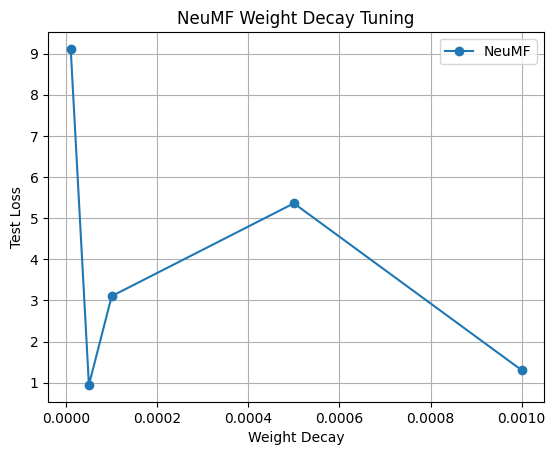

In [ ]:
NeuMF_weights2 = [0.00001,0.00005,0.0001,0.0005,0.001]
NeuMF_weights_losses2 = []

for w in NeuMF_weights2:
  model = NeuMF(num_users, num_items, emb_size=250,hidden_size=85, final_size = 7)
  print("The weight decay is:",w)
  loss = train_epocs(model, epochs=10, lr=0.03, wd = w)
  NeuMF_weights_losses2.append(loss)

plt.plot(NeuMF_weights2, NeuMF_weights_losses2, marker='o', label='NeuMF')
plt.title('NeuMF Weight Decay Tuning')
plt.xlabel('Weight Decay')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)

plt.show()

Number of Epoch Tuning

The Number of Epoch: 5
The test MSE loss is 13.28 
The Number of Epoch: 10
The test MSE loss is 0.95 
The Number of Epoch: 20
The test MSE loss is 0.93 
The Number of Epoch: 30
The test MSE loss is 0.83 
The Number of Epoch: 40
The test MSE loss is 0.78 
The Number of Epoch: 50
The test MSE loss is 0.78 


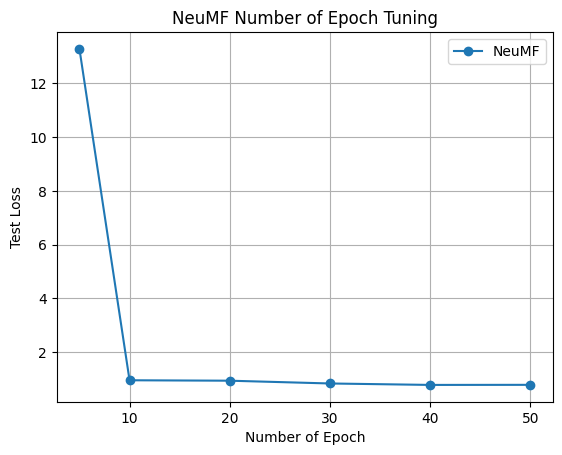

In [ ]:
# the best lr = 0.03, the best hidden layer size = 85, the best embedding size is 250,final size = 7, weight decay = 0.00005
NeuMF_epoch = [5,10,20,30,40,50]
NeuMF_epoch_losses = []

for e in NeuMF_epoch:
  model = NeuMF(num_users, num_items, emb_size=250,hidden_size=85, final_size = 7)
  print("The Number of Epoch:",e)
  loss = train_epocs(model, epochs=e, lr=0.03, wd = 0.00005)
  NeuMF_epoch_losses.append(loss)

plt.plot(NeuMF_epoch, NeuMF_epoch_losses, marker='o', label='NeuMF')
plt.title('NeuMF Number of Epoch Tuning')
plt.xlabel('Number of Epoch')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)

plt.show()

Thus for NeuMF, the best lr = 0.03, the best hidden layer size = 85, the best embedding size is 250,final size = 7, weight decay = 0.00005, number of epochs = 40